# Lombard lending: Modeling lending values

Based on Juri (2014), Lending Values and Liquidity Risk

Applied Credit Risk Modeling Seminar FS2021

Hubert Mrugala and Wenqi Li

# --- Descriptive Statistics ---

## Packages, functions and the data

In [1]:
# Loading packages
import numpy as np
import pandas as pd
import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels
import scipy.stats as st

In [2]:
# Calculate log returns
def log_returns(prices):
    return np.log(prices/prices.shift(1))

def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['ADTV - Last month','ADTV - Last three years']) \
                        .transpose()
    return adtv

# ---------------------------------

def mean(log_prices):
    return log_prices.mean()

# Return standard deviation of a time series
def std(log_prices):
    return log_prices.std()

# ---------------------------------

def describe(series):
    stats = pd.DataFrame(data=[(series.iloc[-1] - series.iloc[0]) / series.iloc[-1]*100,
                               series.min(),
                               series.max(),
                               series.median(),
                               series.mean(),
                               series.std(),
                               series.skew(),
                               series.kurtosis()],
                         index=['% Change','Min','Max','Median','Mean',
                                'Standard Deviation','Skewness','Kurtosis']).T
    alpha = 0.01
    VaRs = []
    for i in range(len(series.columns)):
        series_i_VaR = value_at_risk(series.iloc[:,i],alpha)
        VaRs.append(series_i_VaR)
    ESs = []
    for i in range(len(series.columns)):
        series_i_ES = expected_shortfall(series.iloc[:,i],alpha)
        ESs.append(series_i_ES)
    
    stats['Value at Risk'] = VaRs
    stats['Expected Shortfall'] = ESs
    
    return stats.T

def coskew(df, bias=False):
    v = df.values
    s1 = sigma = v.std(0, keepdims=True)
    means = v.mean(0, keepdims=True)

    # means is 1 x n (n is number of columns
    # this difference broacasts appropriately
    v1 = v - means

    s2 = sigma ** 2

    v2 = v1 ** 2

    m = v.shape[0]

    skew = pd.DataFrame(v2.T.dot(v1) / s2.T.dot(s1) / m, df.columns, df.columns)

    if not bias:
        skew *= ((m - 1) * m) ** .5 / (m - 2)

    return skew

def cokurt(df, bias=False, fisher=True, variant='middle'):
    v = df.values
    s1 = sigma = v.std(0, keepdims=True)
    means = v.mean(0, keepdims=True)

    # means is 1 x n (n is number of columns
    # this difference broacasts appropriately
    v1 = v - means

    s2 = sigma ** 2
    s3 = sigma ** 3

    v2 = v1 ** 2
    v3 = v1 ** 3

    m = v.shape[0]

    if variant in ['left', 'right']:
        kurt = pd.DataFrame(v3.T.dot(v1) / s3.T.dot(s1) / m, df.columns, df.columns)
        if variant == 'right':
            kurt = kurt.T
    elif variant == 'middle':
        kurt = pd.DataFrame(v2.T.dot(v2) / s2.T.dot(s2) / m, df.columns, df.columns)

    if not bias:
        kurt = kurt * (m ** 2 - 1) / (m - 2) / (m - 3) - 3 * (m - 1) ** 2 / (m - 2) / (m - 3)
    if not fisher:
        kurt += 3

    return kurt

# ---------------------------------

def value_at_risk(returns,alpha):
    returns = returns.sort_values(ascending=True)
    n = len(returns)
    k = int(np.floor(n*alpha))
    return -returns[k-1+1]

def VaR_series(returns):
    VaRs = []
    for i in range(20,len(returns)):
        val_at_risk = value_at_risk(returns.iloc[20:20+i],0.01)
        VaRs.append(val_at_risk)
    VaRs = pd.Series(VaRs,index=returns.index[20:])
    return VaRs

def expected_shortfall(returns,alpha):
    var = -value_at_risk(returns,alpha)
    return -returns[returns<var].mean()

def compounded(logs):
    start = 1
    end = len(logs)

    comp = []
    for i in range(start,end):
        ret = logs[1:i].sum()
        comp.append(ret)
    comp = pd.Series(comp)
    comp.index = logs.index[1:]
    return comp

In [3]:
start_date = '2018-04-03'
end_date = '2021-04-09'

# Load/Create Data
smi_prices = pd.read_csv('data/smi_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi_prices.index = pd.to_datetime(smi_prices.index)
smi_logs = log_returns(smi_prices)

smi_vols = pd.read_csv('data/smi_volumes.csv',index_col='Date')[start_date:end_date].interpolate()
smi_vols.index = pd.to_datetime(smi_vols.index)

# ---------------------------------

smi20_prices = pd.read_csv('data/smi_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi20_prices.index = pd.to_datetime(smi20_prices.index)
smi20_logs = log_returns(smi20_prices)

sp500_prices = pd.read_csv('data/sp500_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
sp500_prices.index = pd.to_datetime(sp500_prices.index)
sp500_logs = log_returns(sp500_prices)

# ---------------------------------

selected = ['Credit Suisse','Richemont','Swisscom','SGS']

selected_prices = smi_prices[selected]
selected_vols = smi_vols[selected]
selected_logs = smi_logs[selected]

# ---------------------------------

cs_prices = smi_prices['Credit Suisse']
cs_logs = smi_logs['Credit Suisse']

rich_prices = smi_prices['Richemont']
rich_logs = smi_logs['Richemont']

scom_prices = smi_prices['Swisscom']
scom_logs = smi_logs['Swisscom']

sgs_prices = smi_prices['SGS']
sgs_logs = smi_logs['SGS']

## The Data and Basic Statistics

In [4]:
smi_adtv = ADTV(smi_vols).astype(int)

smi_adtv_sorted = smi_adtv.sort_values(by='ADTV - Last month',ascending=False)
smi_adtv_sorted

,ADTV - Last month,ADTV - Last three years
Credit Suisse,22595016,12663387
UBS,14342477,16710546
ABB,6011700,7633406
Novartis,5362601,5848525
Nestle,4911121,5754748
LafargeHolcim,1969625,2586225
Roche,1687019,1845463
Richemont,1379816,2073134
Swiss Re,1261646,1612901
Alcon,973923,1820399


In [5]:
adtv_sel = smi_adtv.loc[selected]
adtv_sel

,ADTV - Last month,ADTV - Last three years
Credit Suisse,22595016,12663387
Richemont,1379816,2073134
Swisscom,184673,162442
SGS,23095,25434


In [6]:
describe_prices = describe(selected_prices).round(2)
describe_prices

,Credit Suisse,Richemont,Swisscom,SGS
% Change,-43.75,14.32,19.92,23.47
Min,6.20,48.66,375.98,1850.63
Max,15.77,94.72,528.82,2756.00
Median,11.36,72.77,450.12,2330.63
Mean,11.38,71.93,444.20,2335.31
Standard Deviation,1.81,10.27,34.90,160.28
Skewness,-0.18,-0.10,-0.19,0.17
Kurtosis,0.04,-0.69,-0.90,-0.11
Value at Risk,-6.92,-50.53,-378.78,-1998.38
Expected Shortfall,-6.49,-49.72,-377.75,-1929.31


In [7]:
describe_logs = pd.concat([(describe(selected_logs)[1:6]*100).round(2).astype(str) + '%',
           (describe(selected_logs)[6:]).round(2)])
describe_logs

,Credit Suisse,Richemont,Swisscom,SGS
Min,-17.47%,-14.5%,-7.79%,-9.17%
Max,13.92%,10.94%,9.28%,7.91%
Median,0.0%,0.09%,0.02%,0.14%
Mean,-0.05%,0.02%,0.03%,0.04%
Standard Deviation,2.32%,1.87%,1.14%,1.29%
Skewness,-0.8,-0.42,0.07,-0.37
Kurtosis,10.52,7.4,12.23,7.9
Value at Risk,0.06,0.05,0.03,0.04
Expected Shortfall,0.11,0.07,0.05,0.05


## Plots

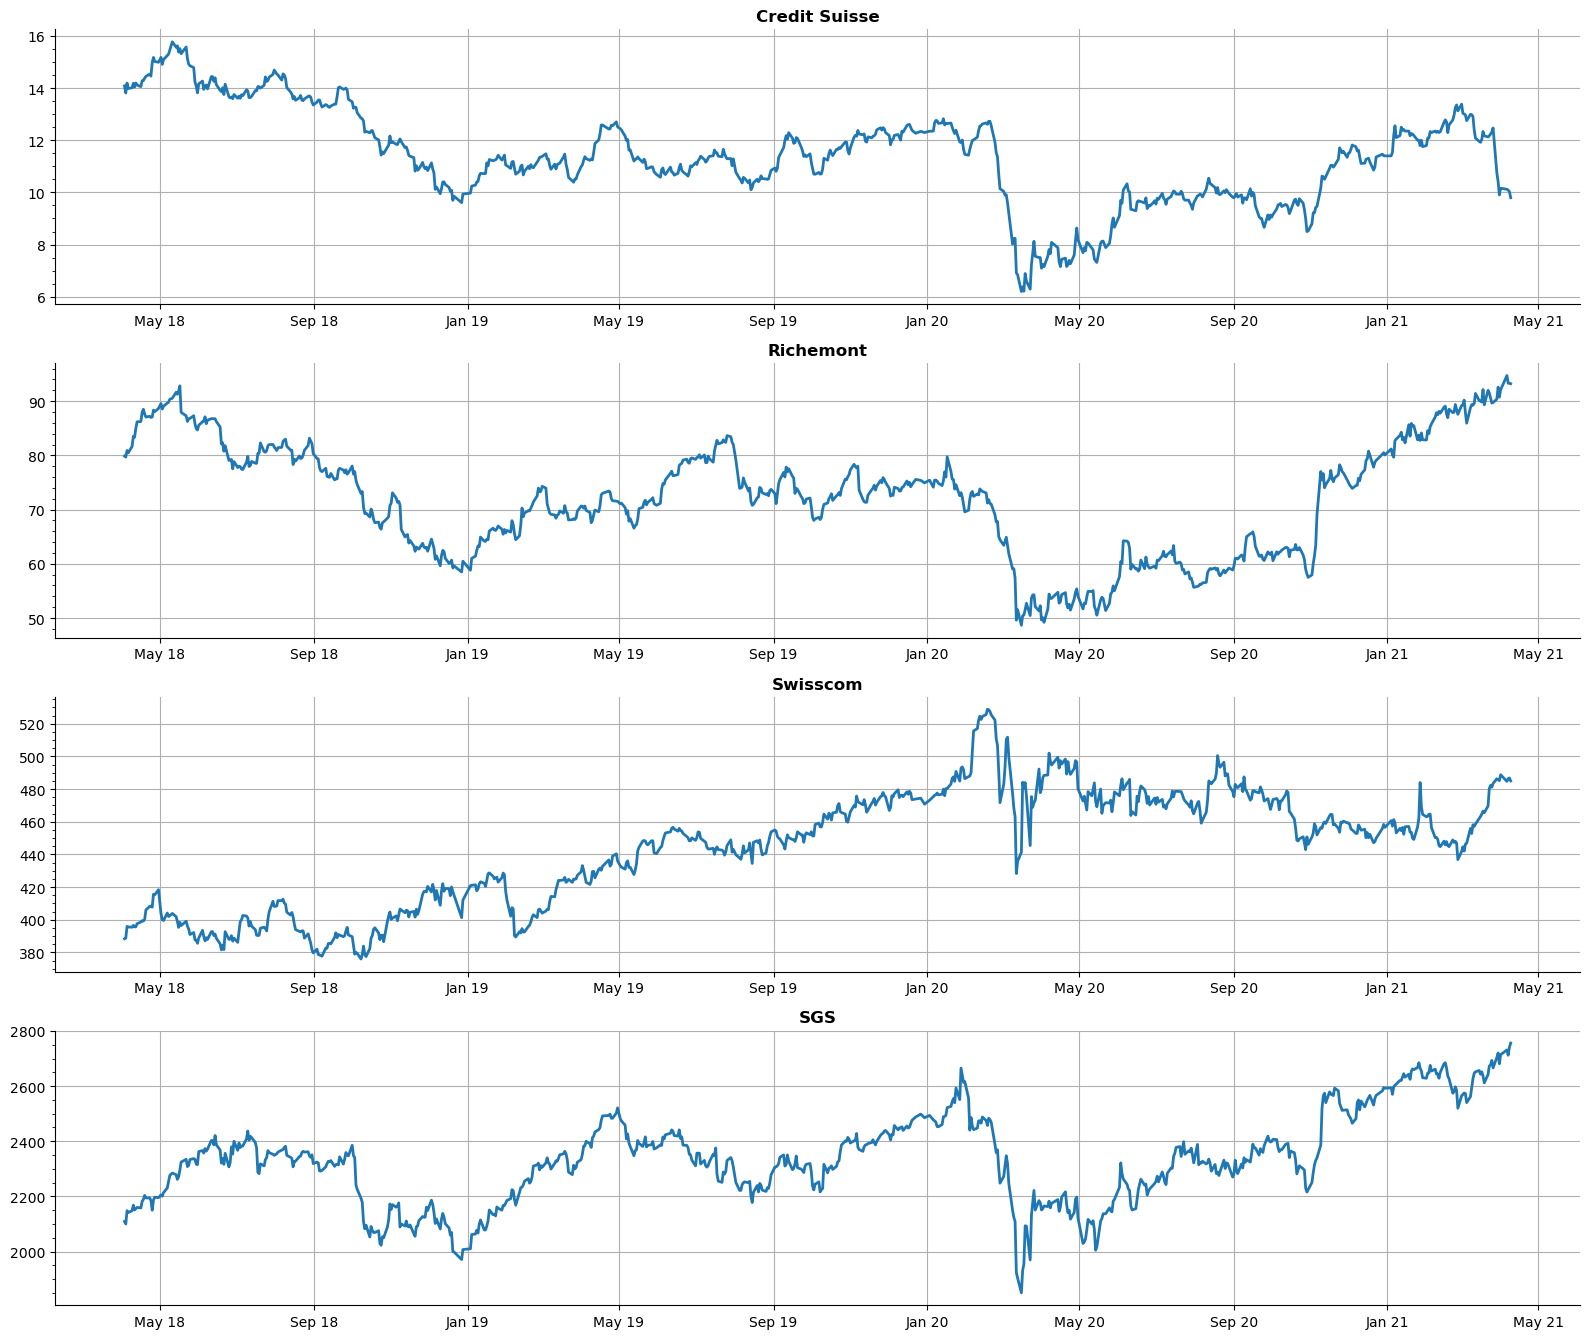

In [8]:
# Price
tcks = selected_prices.columns
f_prices, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*1.5],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_prices.iloc[:,i],lw=2)
    ax[i].set_title(tcks[i],fontweight='bold')

    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

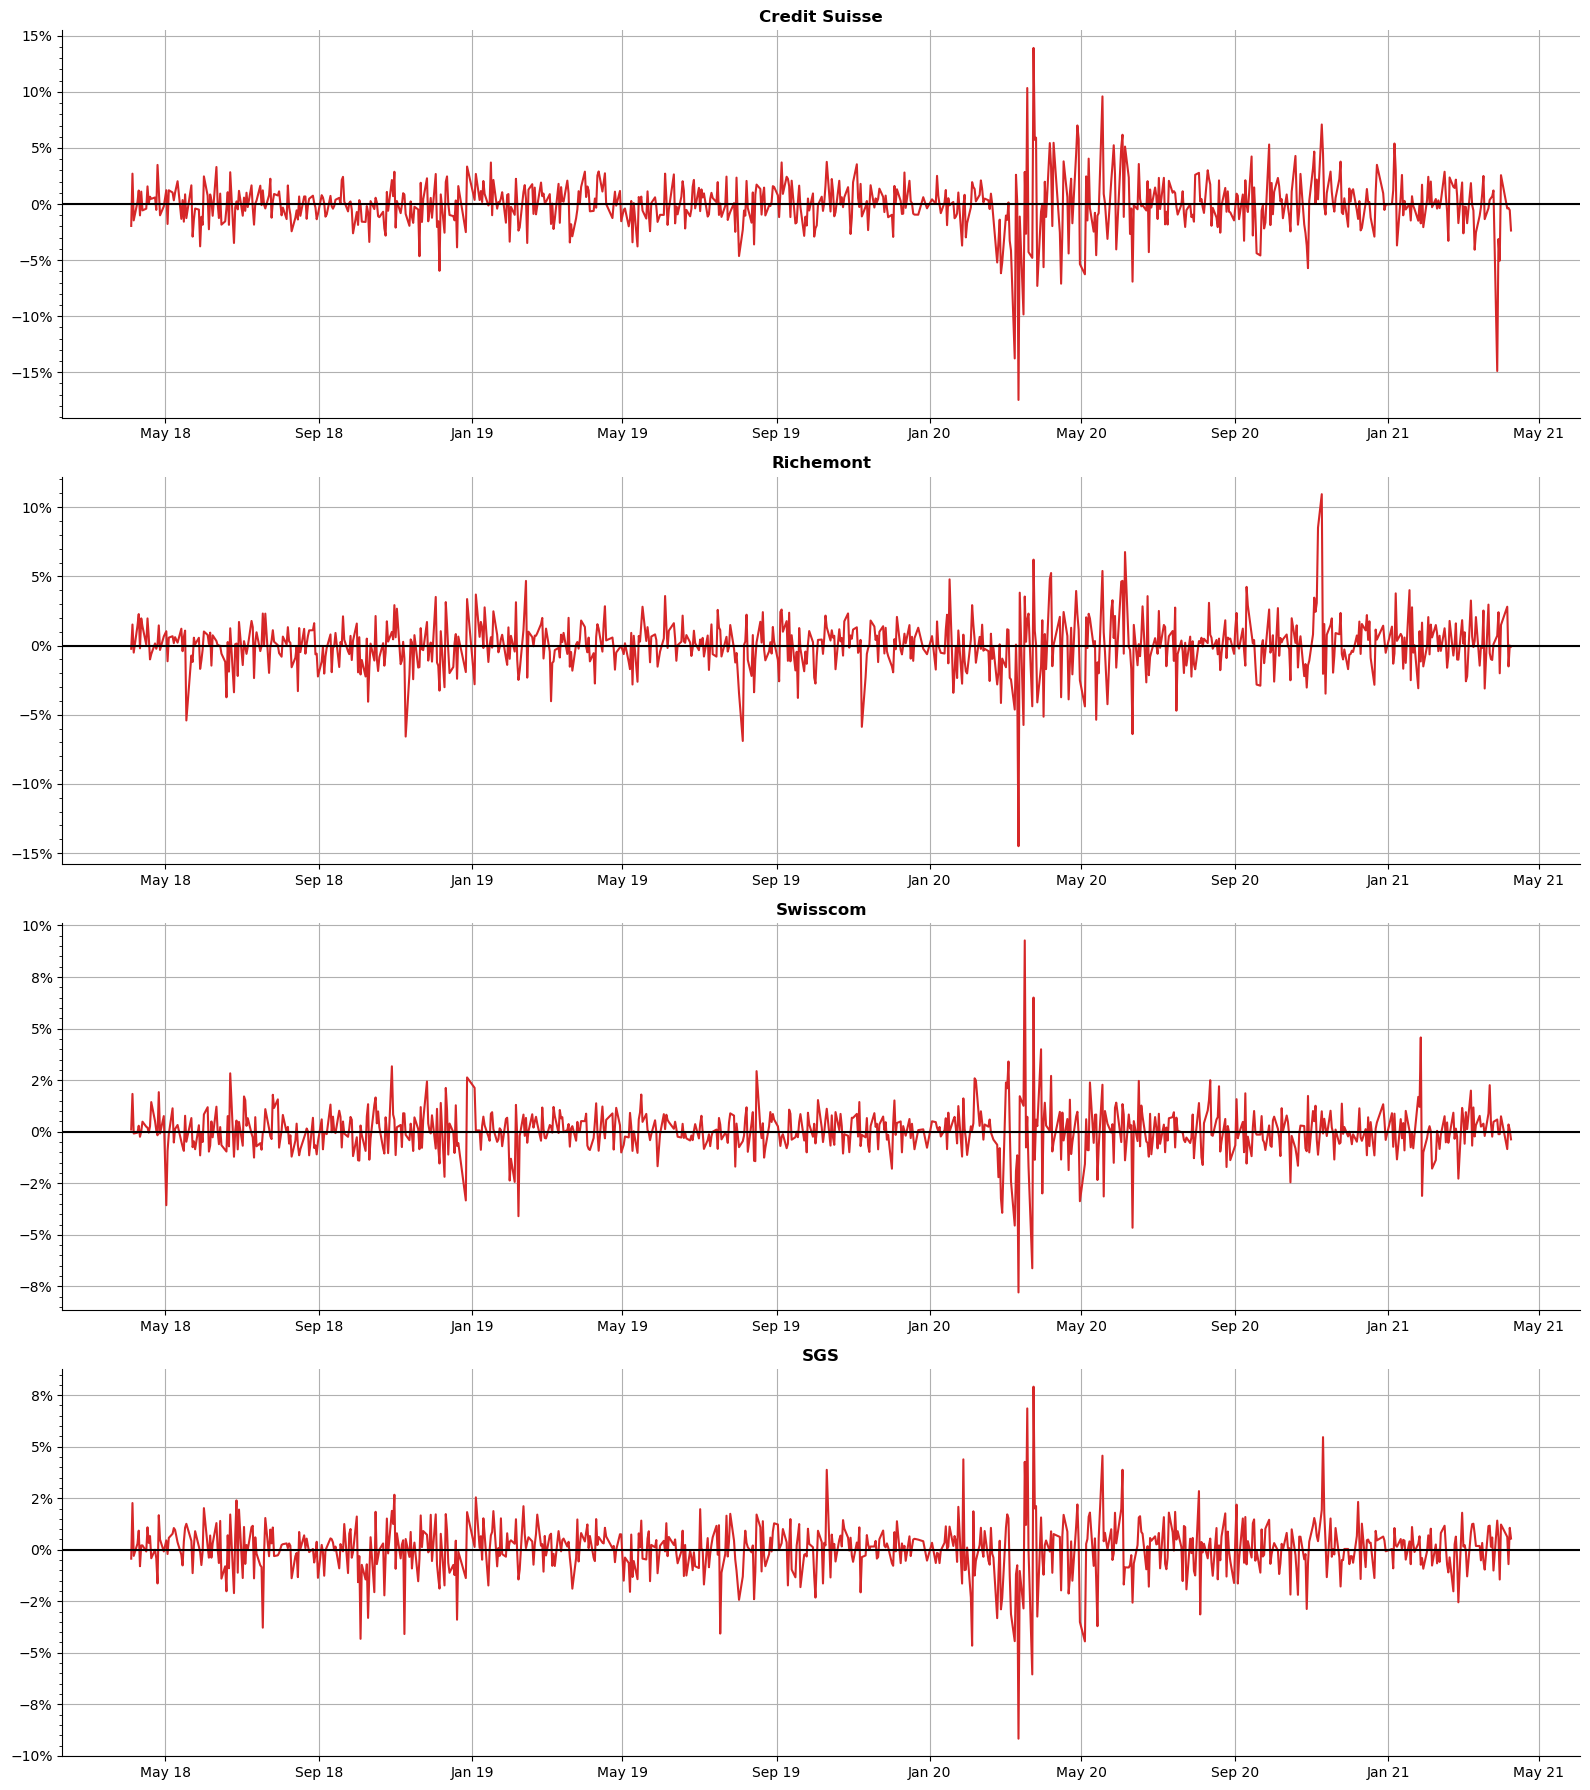

In [9]:
# Log-Returns
tcks = selected_prices.columns
f_logs, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_logs.iloc[:,i]*100,c='C3')
    ax[i].axhline(y=0,c='k')
    ax[i].set_title(tcks[i],fontweight='bold')

    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

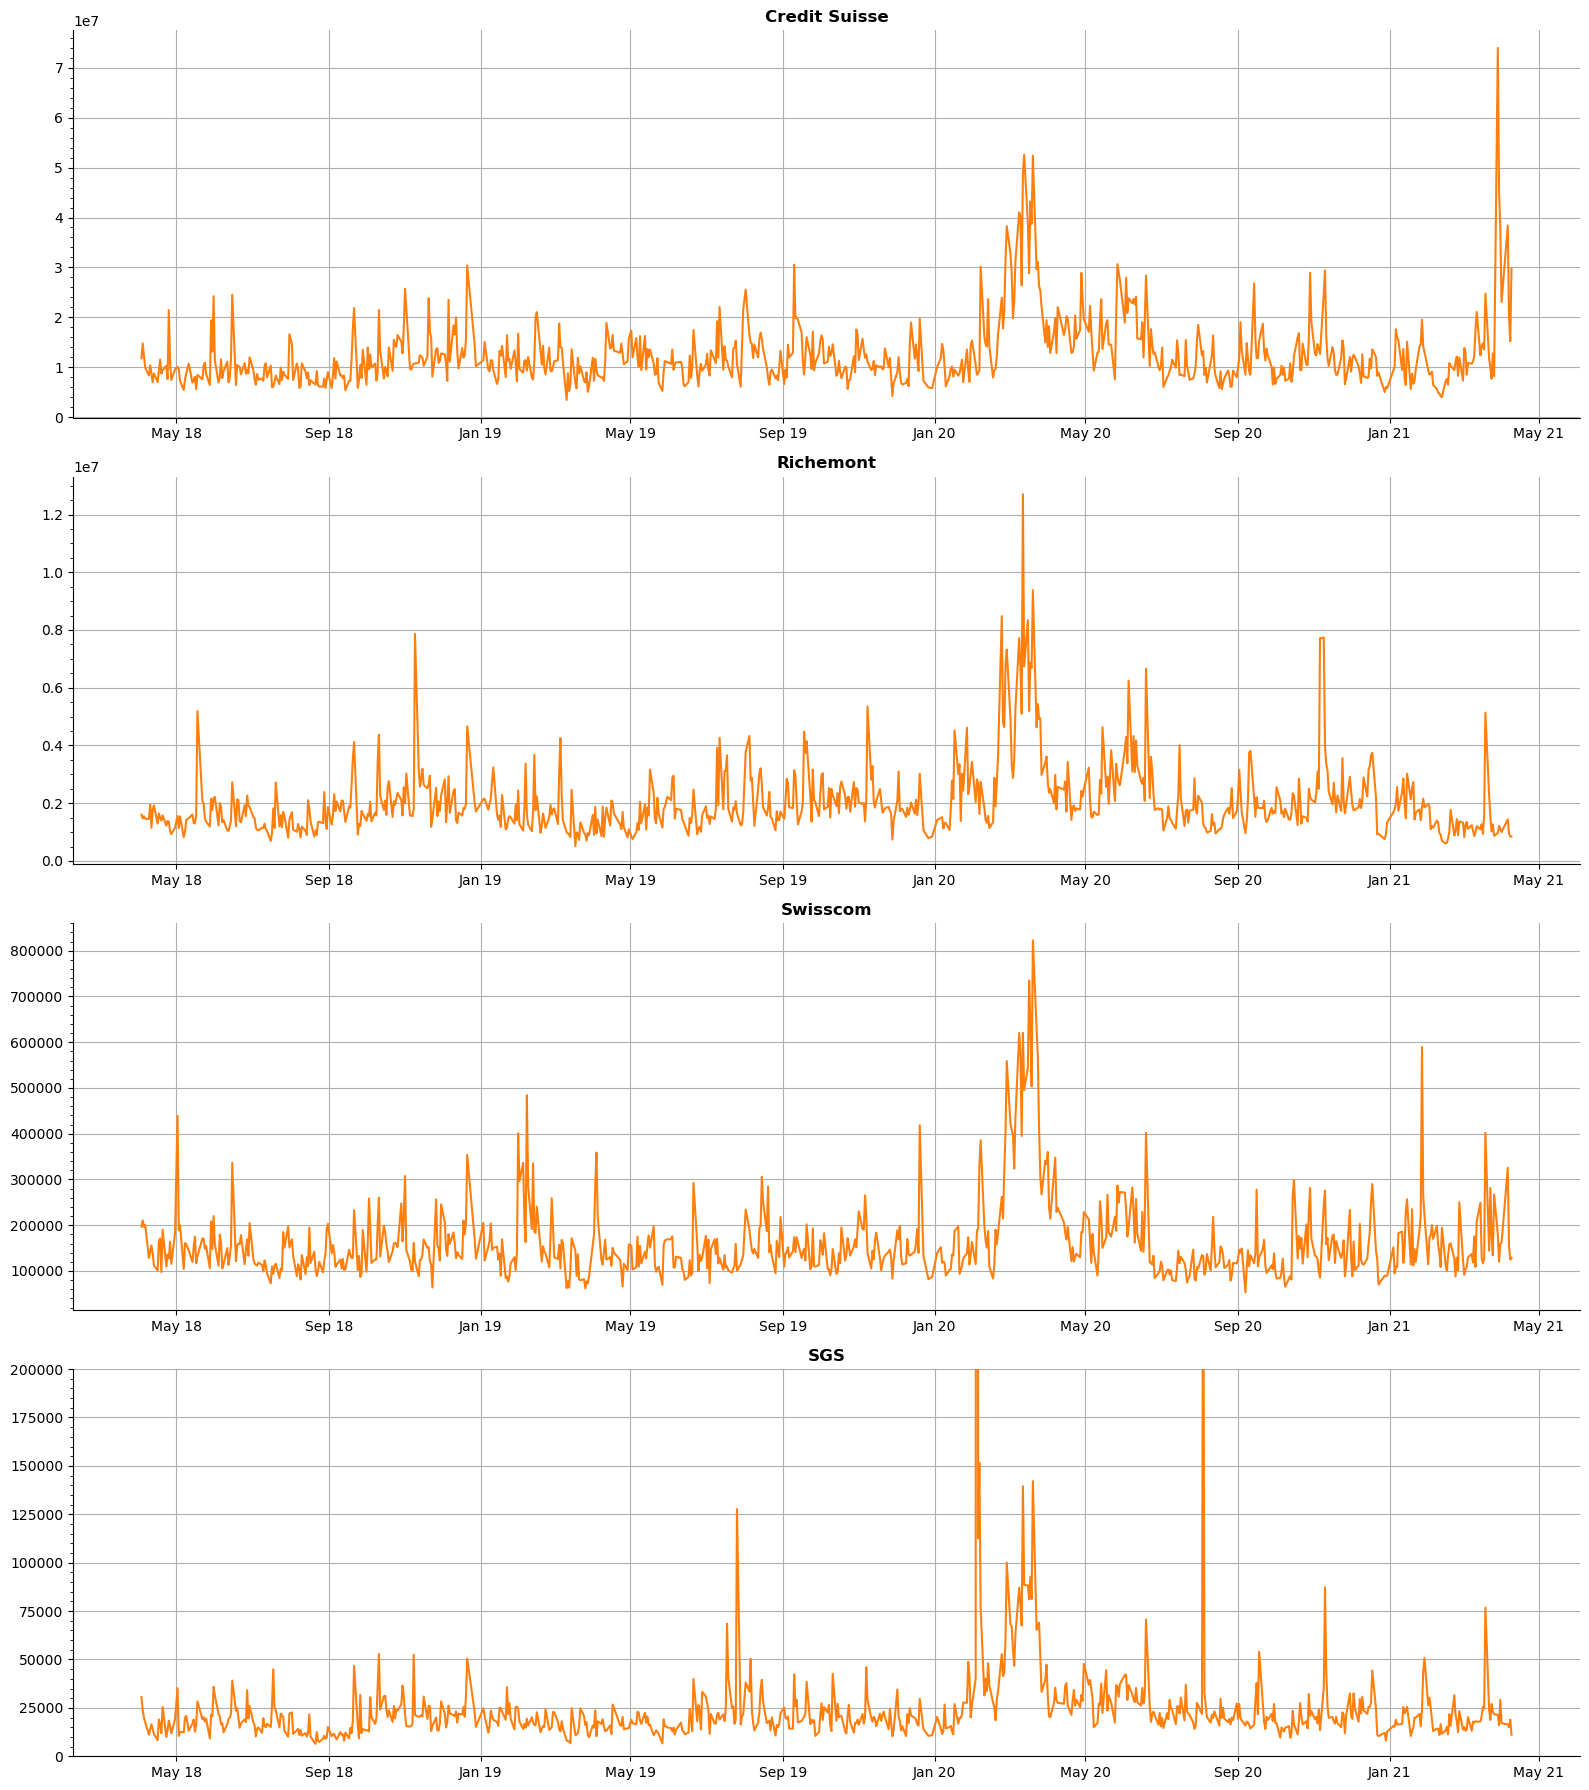

In [10]:
# Volumes
tcks = selected_vols.columns
f_vols, ax = plt.subplots(nrows=len(tcks),ncols=1,
                       figsize=[16,9*2],dpi=100)
for i in range(len(tcks)):
    ax[i].plot(selected_vols.iloc[:,i],c='C1')
    ax[i].set_title(tcks[i],fontweight='bold')
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    ax[3].set_ylim([0,200000])

    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].grid()
plt.tight_layout()

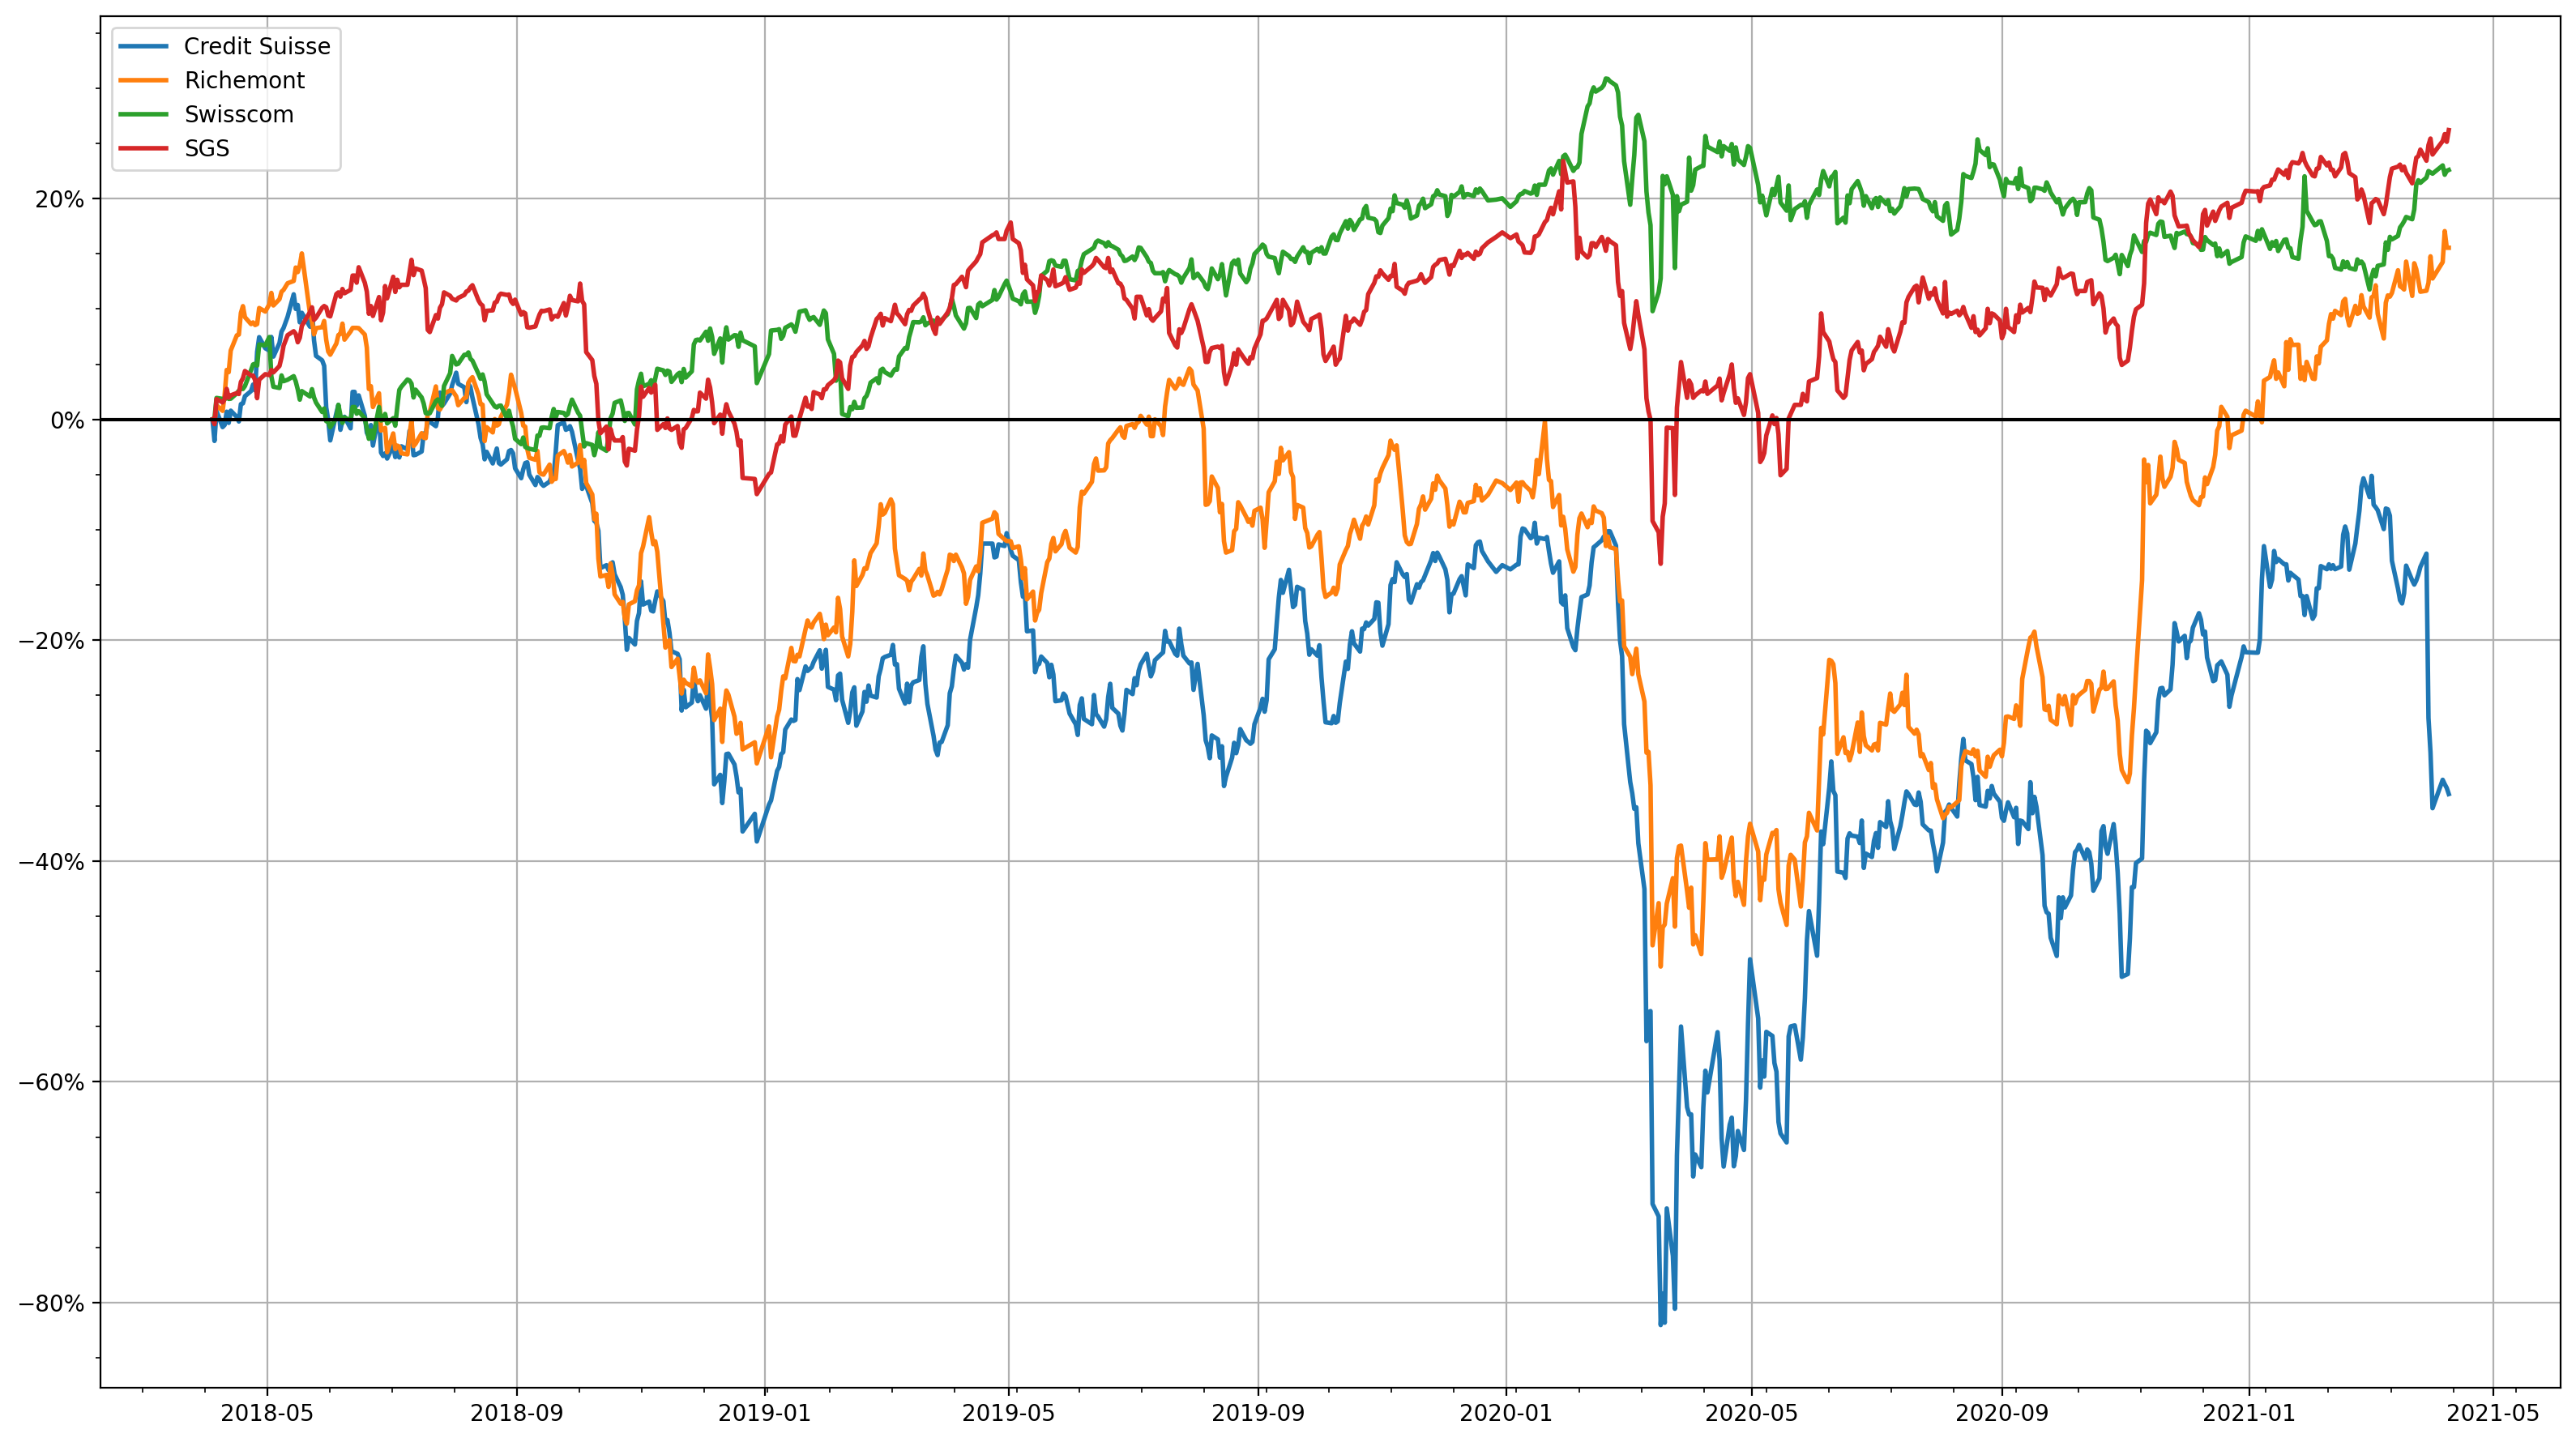

In [11]:
# Compounded logreturns
f_comp, ax = plt.subplots(1,1,figsize=[16,9],dpi=200)

for i in range(4):
    ax.plot(
        compounded(selected_logs.iloc[:,i]*100),
        lw=2
    )
ax.axhline(y=0,color='k')
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

ax.grid()
ax.legend(selected)
plt.tight_layout()

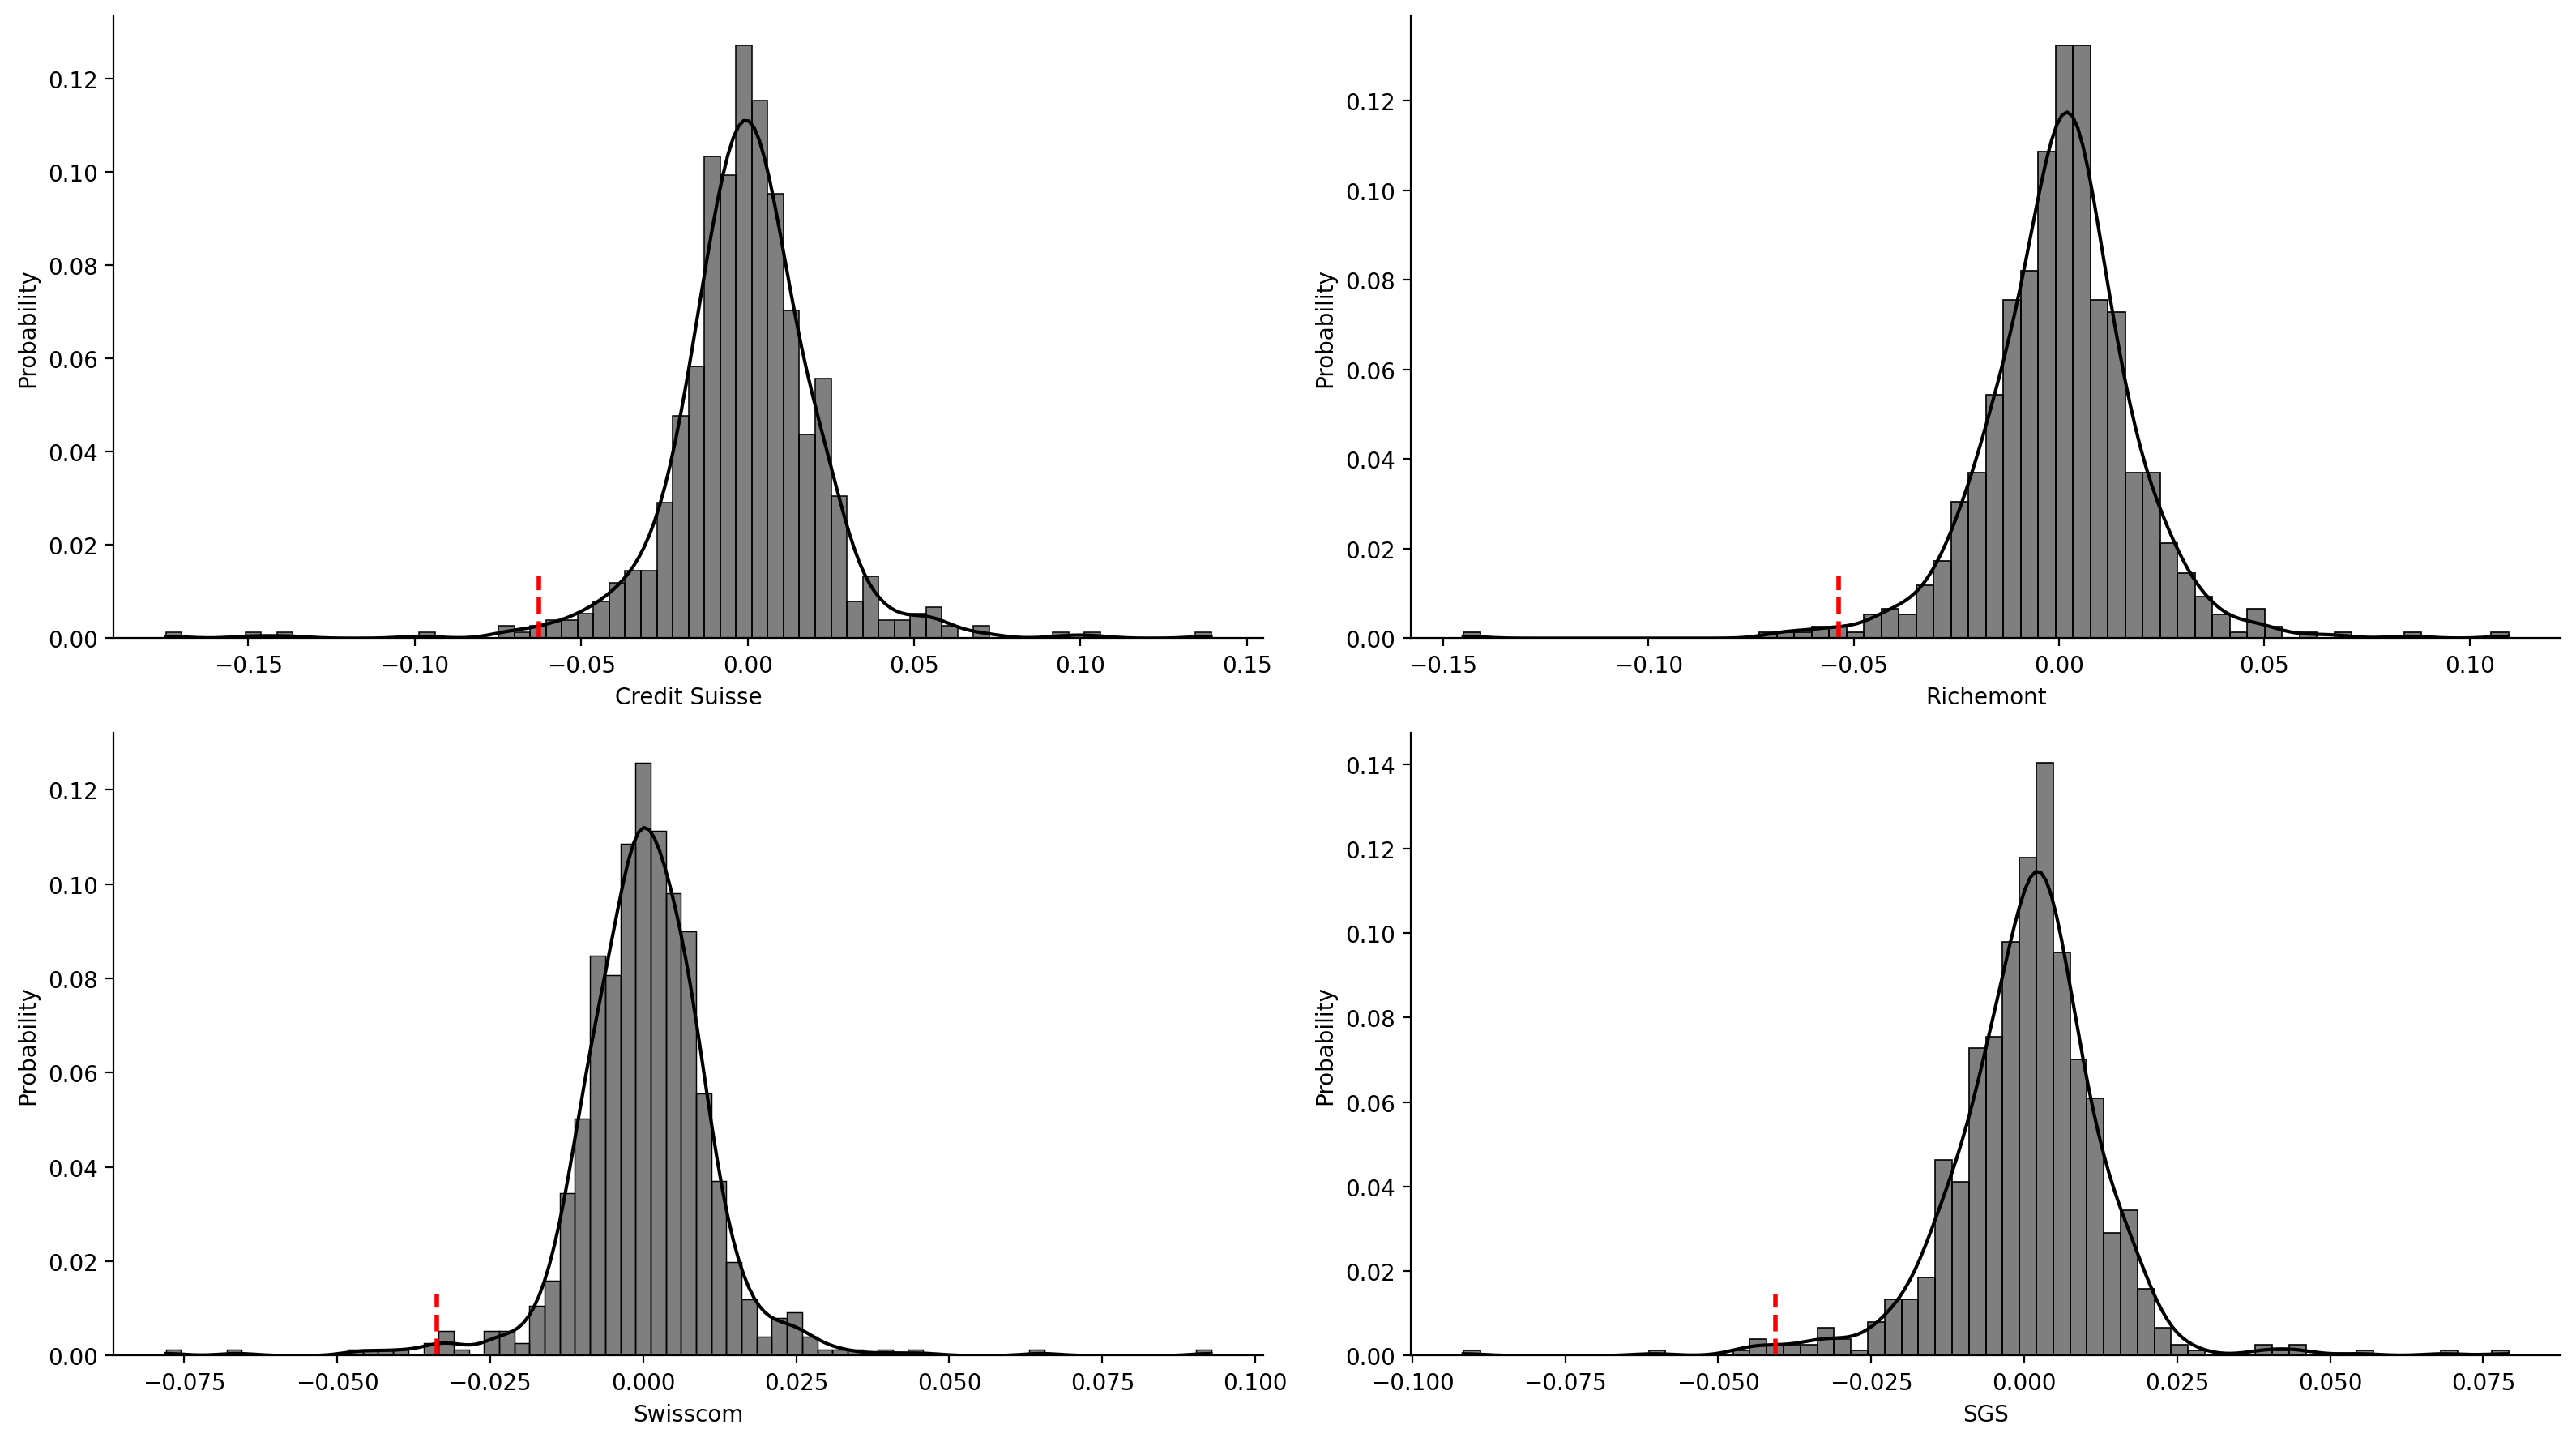

In [12]:
f_dist, ax = plt.subplots(2,2,figsize=[16,9],dpi=200)

sns.histplot(ax=ax[0,0],
             data=cs_logs,
             kde=True,
             stat='probability',
             color='k')
ax[0,0].axvline(-value_at_risk(cs_logs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[0,1],
             data=rich_logs,
             kde=True,
             stat='probability',
             color='k')
ax[0,1].axvline(-value_at_risk(rich_logs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[1,0],
             data=scom_logs,
             kde=True,
             stat='probability',
             color='k')
ax[1,0].axvline(-value_at_risk(scom_logs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.histplot(ax=ax[1,1],
             data=sgs_logs,
             kde=True,
             stat='probability',
             color='k')
ax[1,1].axvline(-value_at_risk(sgs_logs,0.01),
               ymin=0,ymax=0.1,
               ls='--',c='r',lw=2)

sns.despine()
plt.tight_layout()

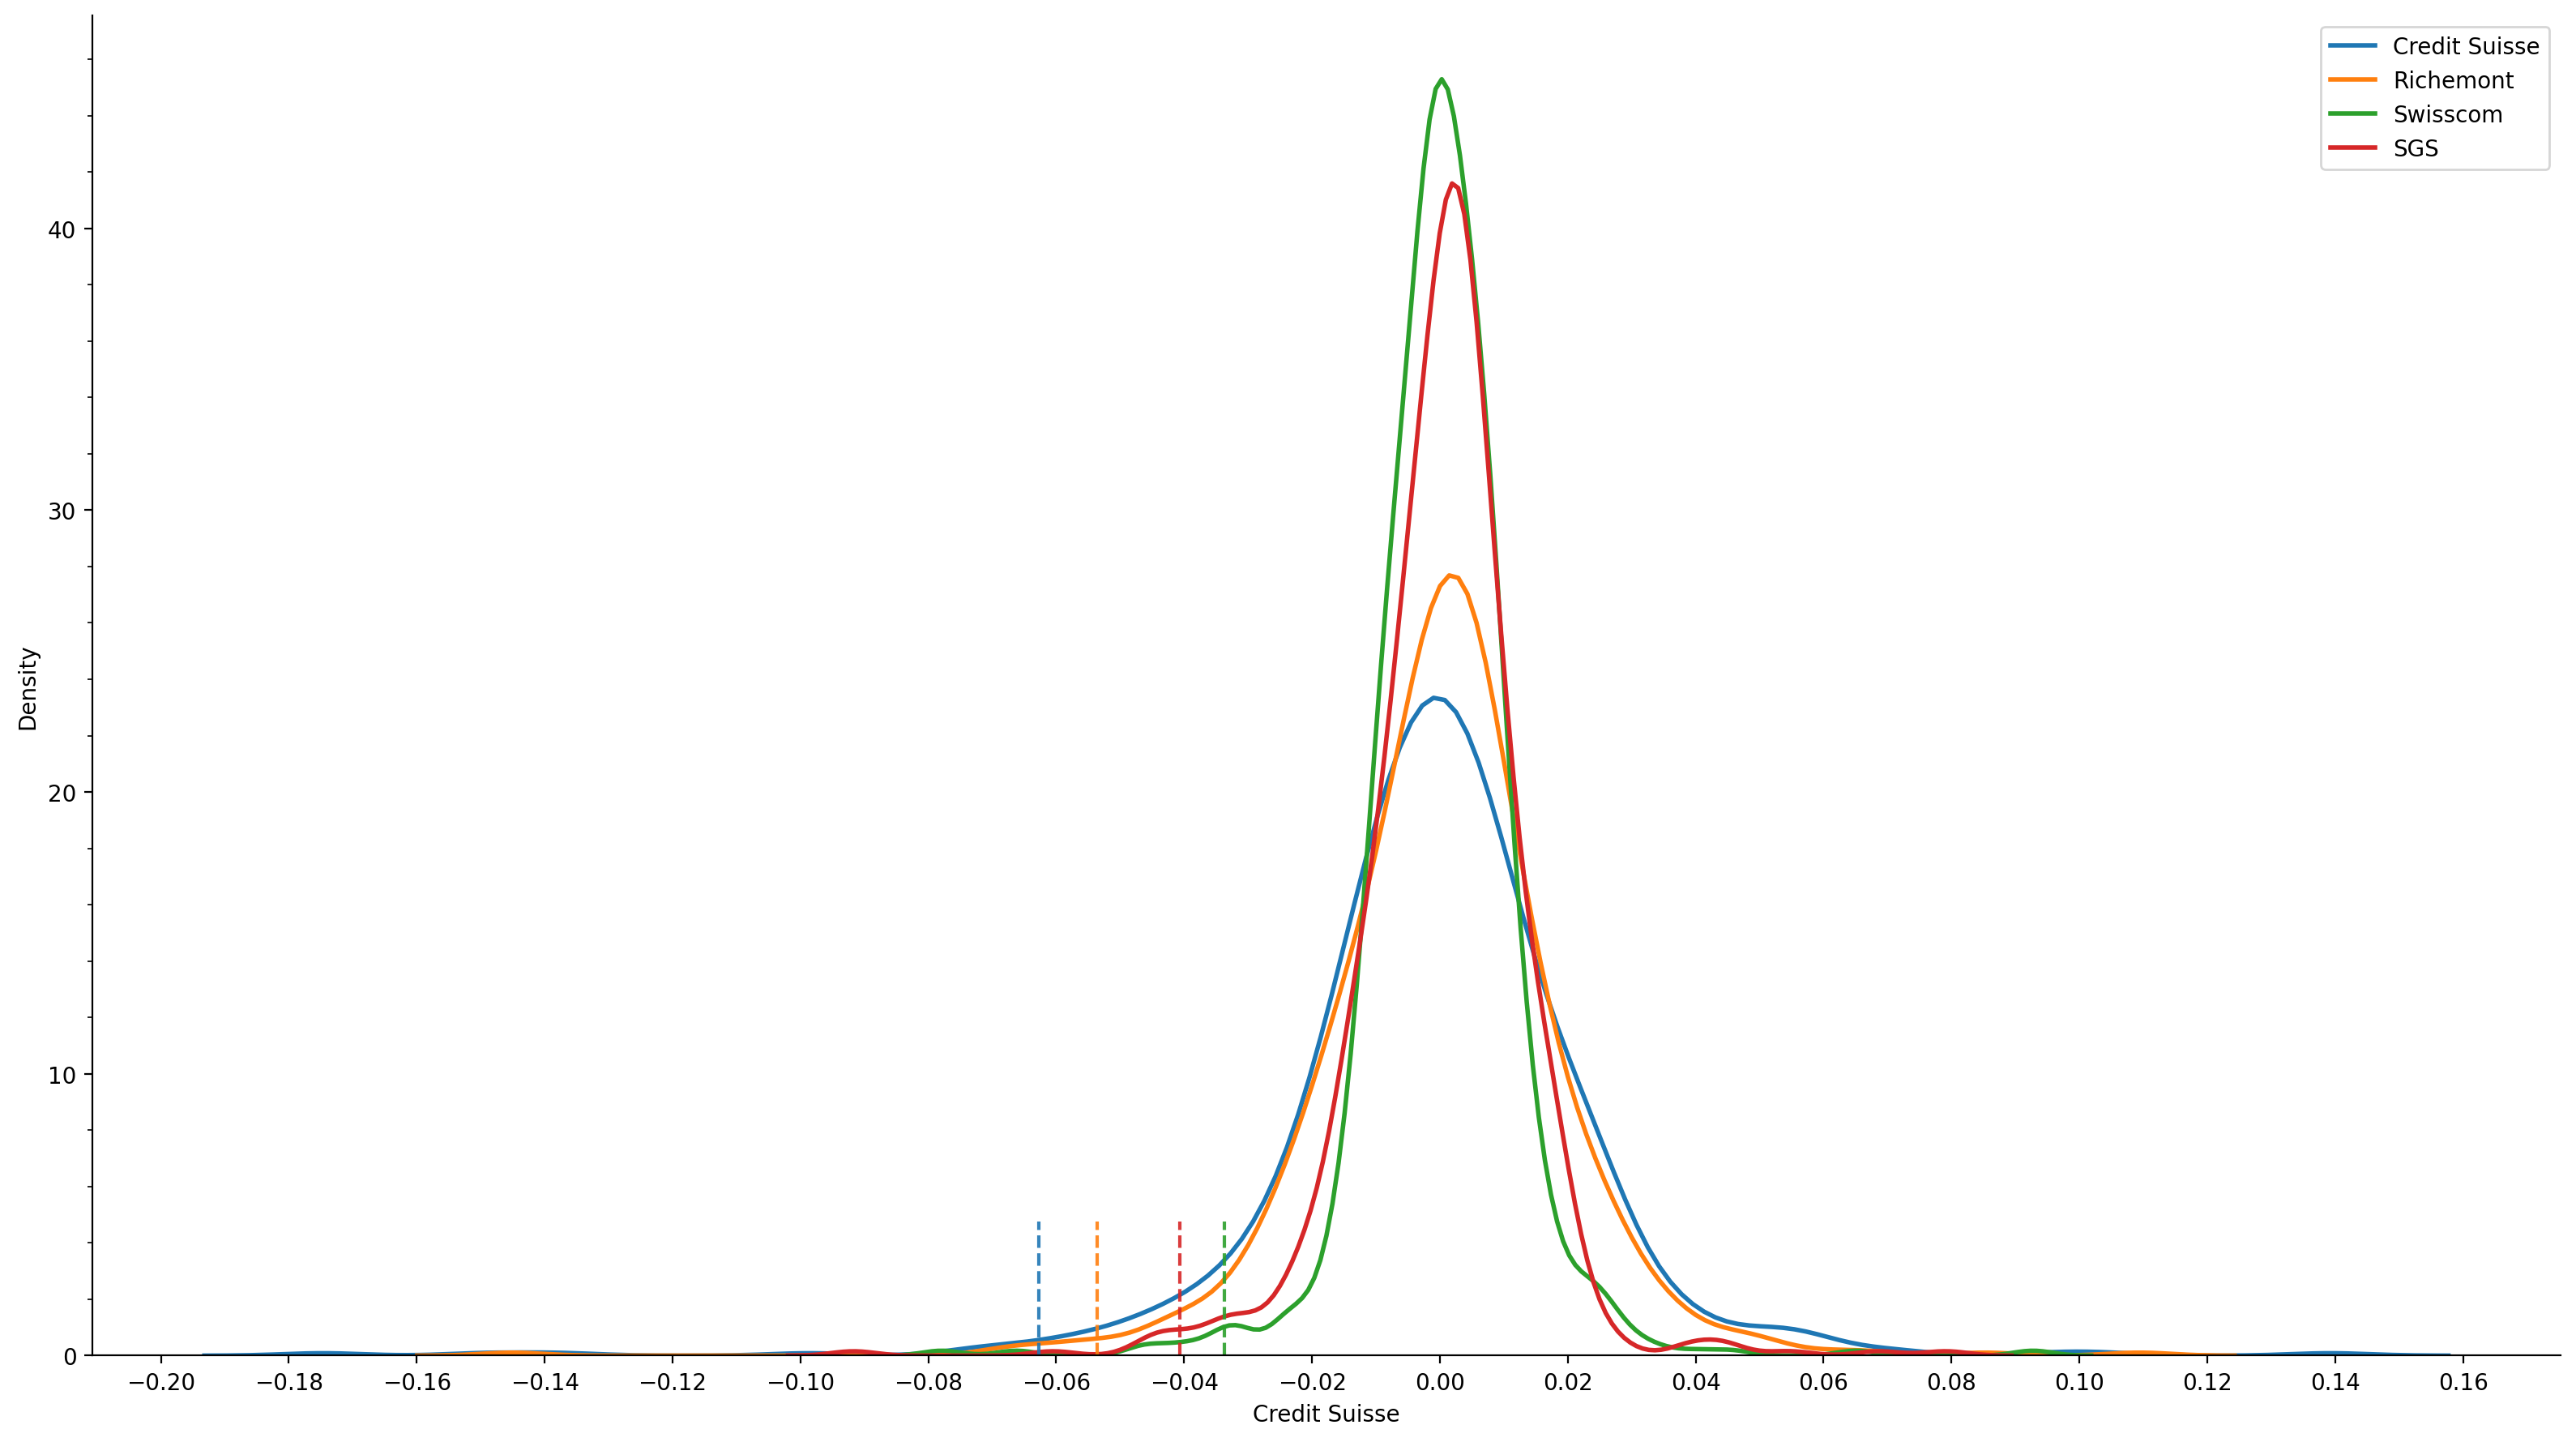

In [13]:
f_dist2, ax = plt.subplots(1,1,figsize=[16,9],dpi=200)

sns.kdeplot(cs_logs,lw=2)
sns.kdeplot(rich_logs,lw=2)
sns.kdeplot(scom_logs,lw=2)
sns.kdeplot(sgs_logs,lw=2)

ax.axvline(-value_at_risk(cs_logs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C0',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(rich_logs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C1',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(scom_logs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C2',
           lw=1.5,alpha=0.9)
ax.axvline(-value_at_risk(sgs_logs,0.01),
           ymin=0,ymax=0.1,
           ls='--',c='C3',
           lw=1.5,alpha=0.9)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

sns.despine()
plt.legend(selected)

plt.tight_layout()

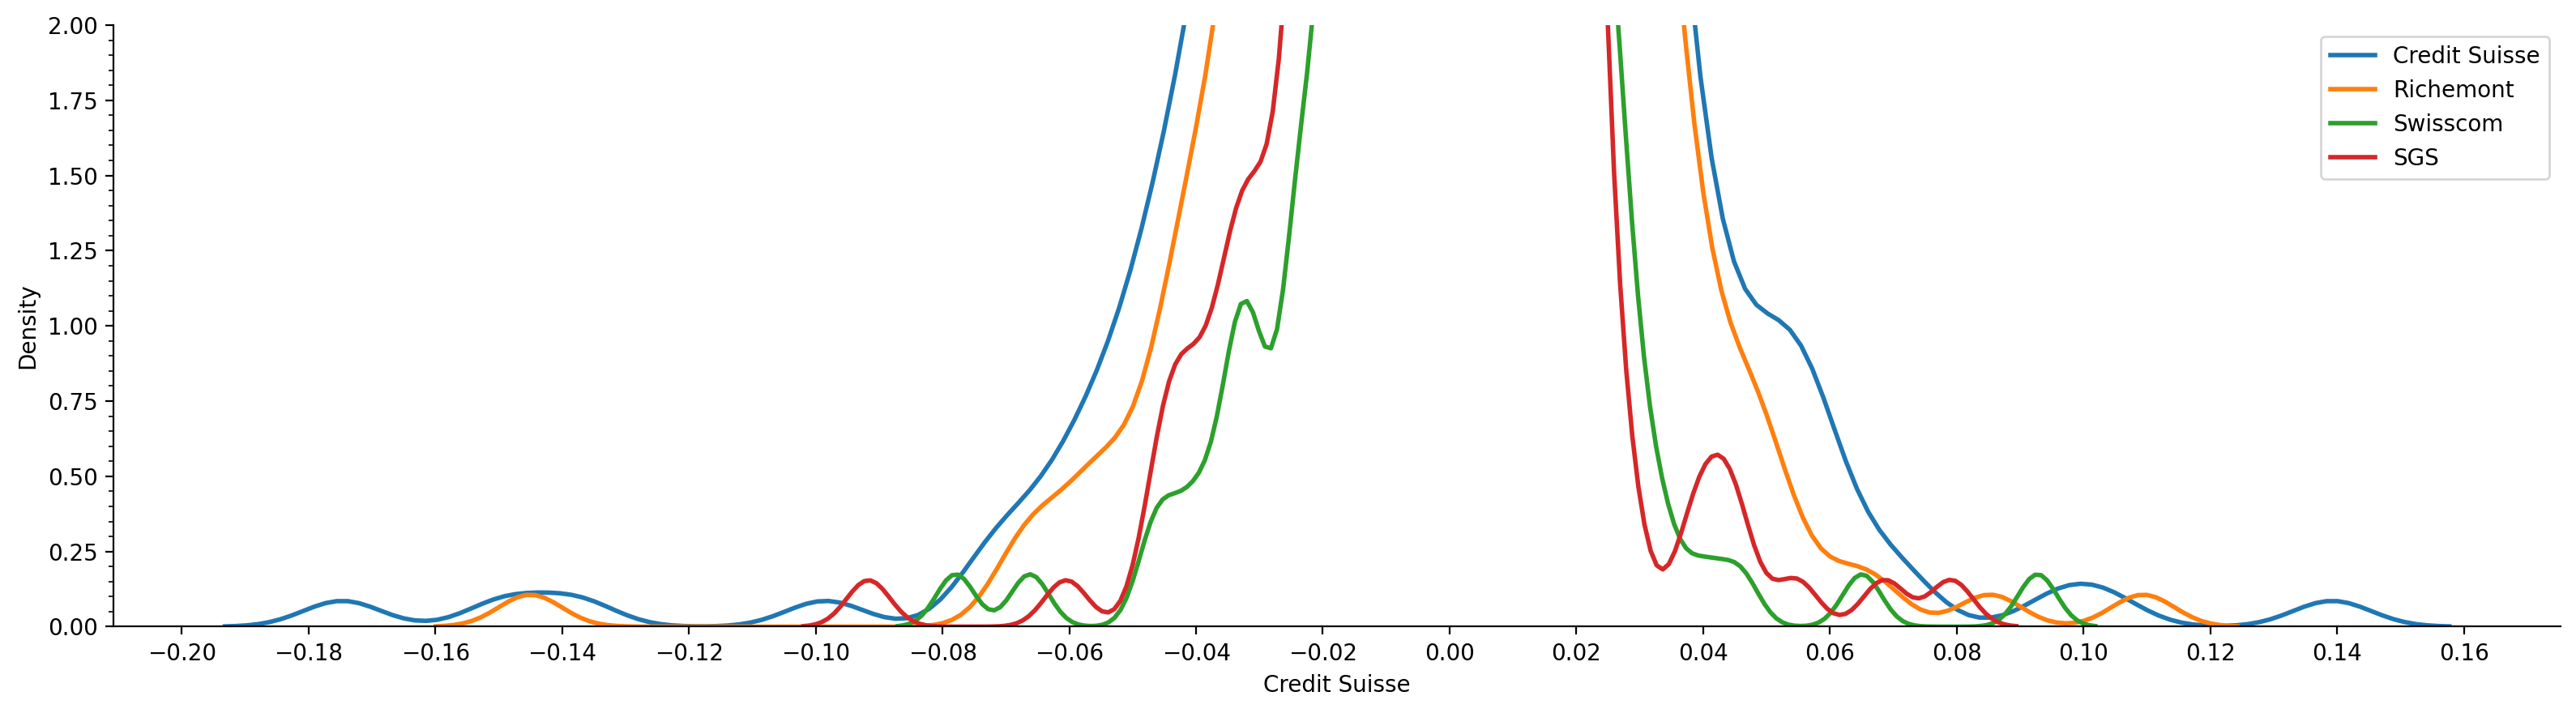

In [14]:
f_dist2tail, ax = plt.subplots(1,1,figsize=[16,9/2],dpi=200)

sns.kdeplot(cs_logs,lw=2)
sns.kdeplot(rich_logs,lw=2)
sns.kdeplot(scom_logs,lw=2)
sns.kdeplot(sgs_logs,lw=2)

ax.set_ylim(0,2)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

sns.despine()
plt.legend(selected)

plt.tight_layout()

## Systemic risk

In [15]:
betas = []
for  i in range(4):
    b = pd.concat([
        selected_logs.iloc[:,i],
        smi20_logs],
        axis=1).interpolate().iloc[1:].cov().iloc[0,1] / smi20_logs.var()
    betas.append(b[0])
betas = pd.DataFrame(betas,index=selected,columns=['Beta'])
betas.round(2)

,Beta
Credit Suisse,1.50
Richemont,1.13
Swisscom,0.66
SGS,0.89


In [16]:
all_returns = pd.concat([selected_logs,smi20_logs,sp500_logs],axis=1).interpolate()[1:]

moments = pd.DataFrame([
    [i for i in all_returns.corr().iloc[-2,:-2]],
    [i for i in coskew(all_returns).iloc[-2,:-2]],
    [i for i in cokurt(all_returns).iloc[-2,:-2]]
    ],
    index=['Correlation','Coskewness','Cokurtosis'],columns=selected).T
moments.round(2)

,Correlation,Coskewness,Cokurtosis
Credit Suisse,0.70,-0.96,9.41
Richemont,0.65,-1.04,6.59
Swisscom,0.64,-0.97,8.23
SGS,0.75,-0.84,8.84


In [17]:
sys_risk = pd.concat([betas,moments],axis=1).round(2).iloc[:,[0,2,3]]
sys_risk

,Beta,Coskewness,Cokurtosis
Credit Suisse,1.50,-0.96,9.41
Richemont,1.13,-1.04,6.59
Swisscom,0.66,-0.97,8.23
SGS,0.89,-0.84,8.84


In [18]:
corr = all_returns.corr().round(2)
corr

,Credit Suisse,Richemont,Swisscom,SGS,SMI20,SP500
Credit Suisse,1.00,0.63,0.41,0.56,0.70,0.55
Richemont,0.63,1.00,0.33,0.54,0.65,0.49
Swisscom,0.41,0.33,1.00,0.51,0.64,0.34
SGS,0.56,0.54,0.51,1.00,0.75,0.44
SMI20,0.70,0.65,0.64,0.75,1.00,0.58
SP500,0.55,0.49,0.34,0.44,0.58,1.00


In [19]:
corr_kendall = all_returns.corr('kendall').round(2)
corr_kendall

,Credit Suisse,Richemont,Swisscom,SGS,SMI20,SP500
Credit Suisse,1.00,0.42,0.23,0.32,0.43,0.30
Richemont,0.42,1.00,0.18,0.39,0.46,0.29
Swisscom,0.23,0.18,1.00,0.29,0.37,0.12
SGS,0.32,0.39,0.29,1.00,0.52,0.25
SMI20,0.43,0.46,0.37,0.52,1.00,0.33
SP500,0.30,0.29,0.12,0.25,0.33,1.00


In [20]:
corr_spearman = all_returns.corr('spearman').round(2)
corr_spearman

,Credit Suisse,Richemont,Swisscom,SGS,SMI20,SP500
Credit Suisse,1.00,0.59,0.32,0.44,0.59,0.42
Richemont,0.59,1.00,0.26,0.54,0.64,0.41
Swisscom,0.32,0.26,1.00,0.42,0.52,0.17
SGS,0.44,0.54,0.42,1.00,0.69,0.36
SMI20,0.59,0.64,0.52,0.69,1.00,0.46
SP500,0.42,0.41,0.17,0.36,0.46,1.00


## Value at Risk

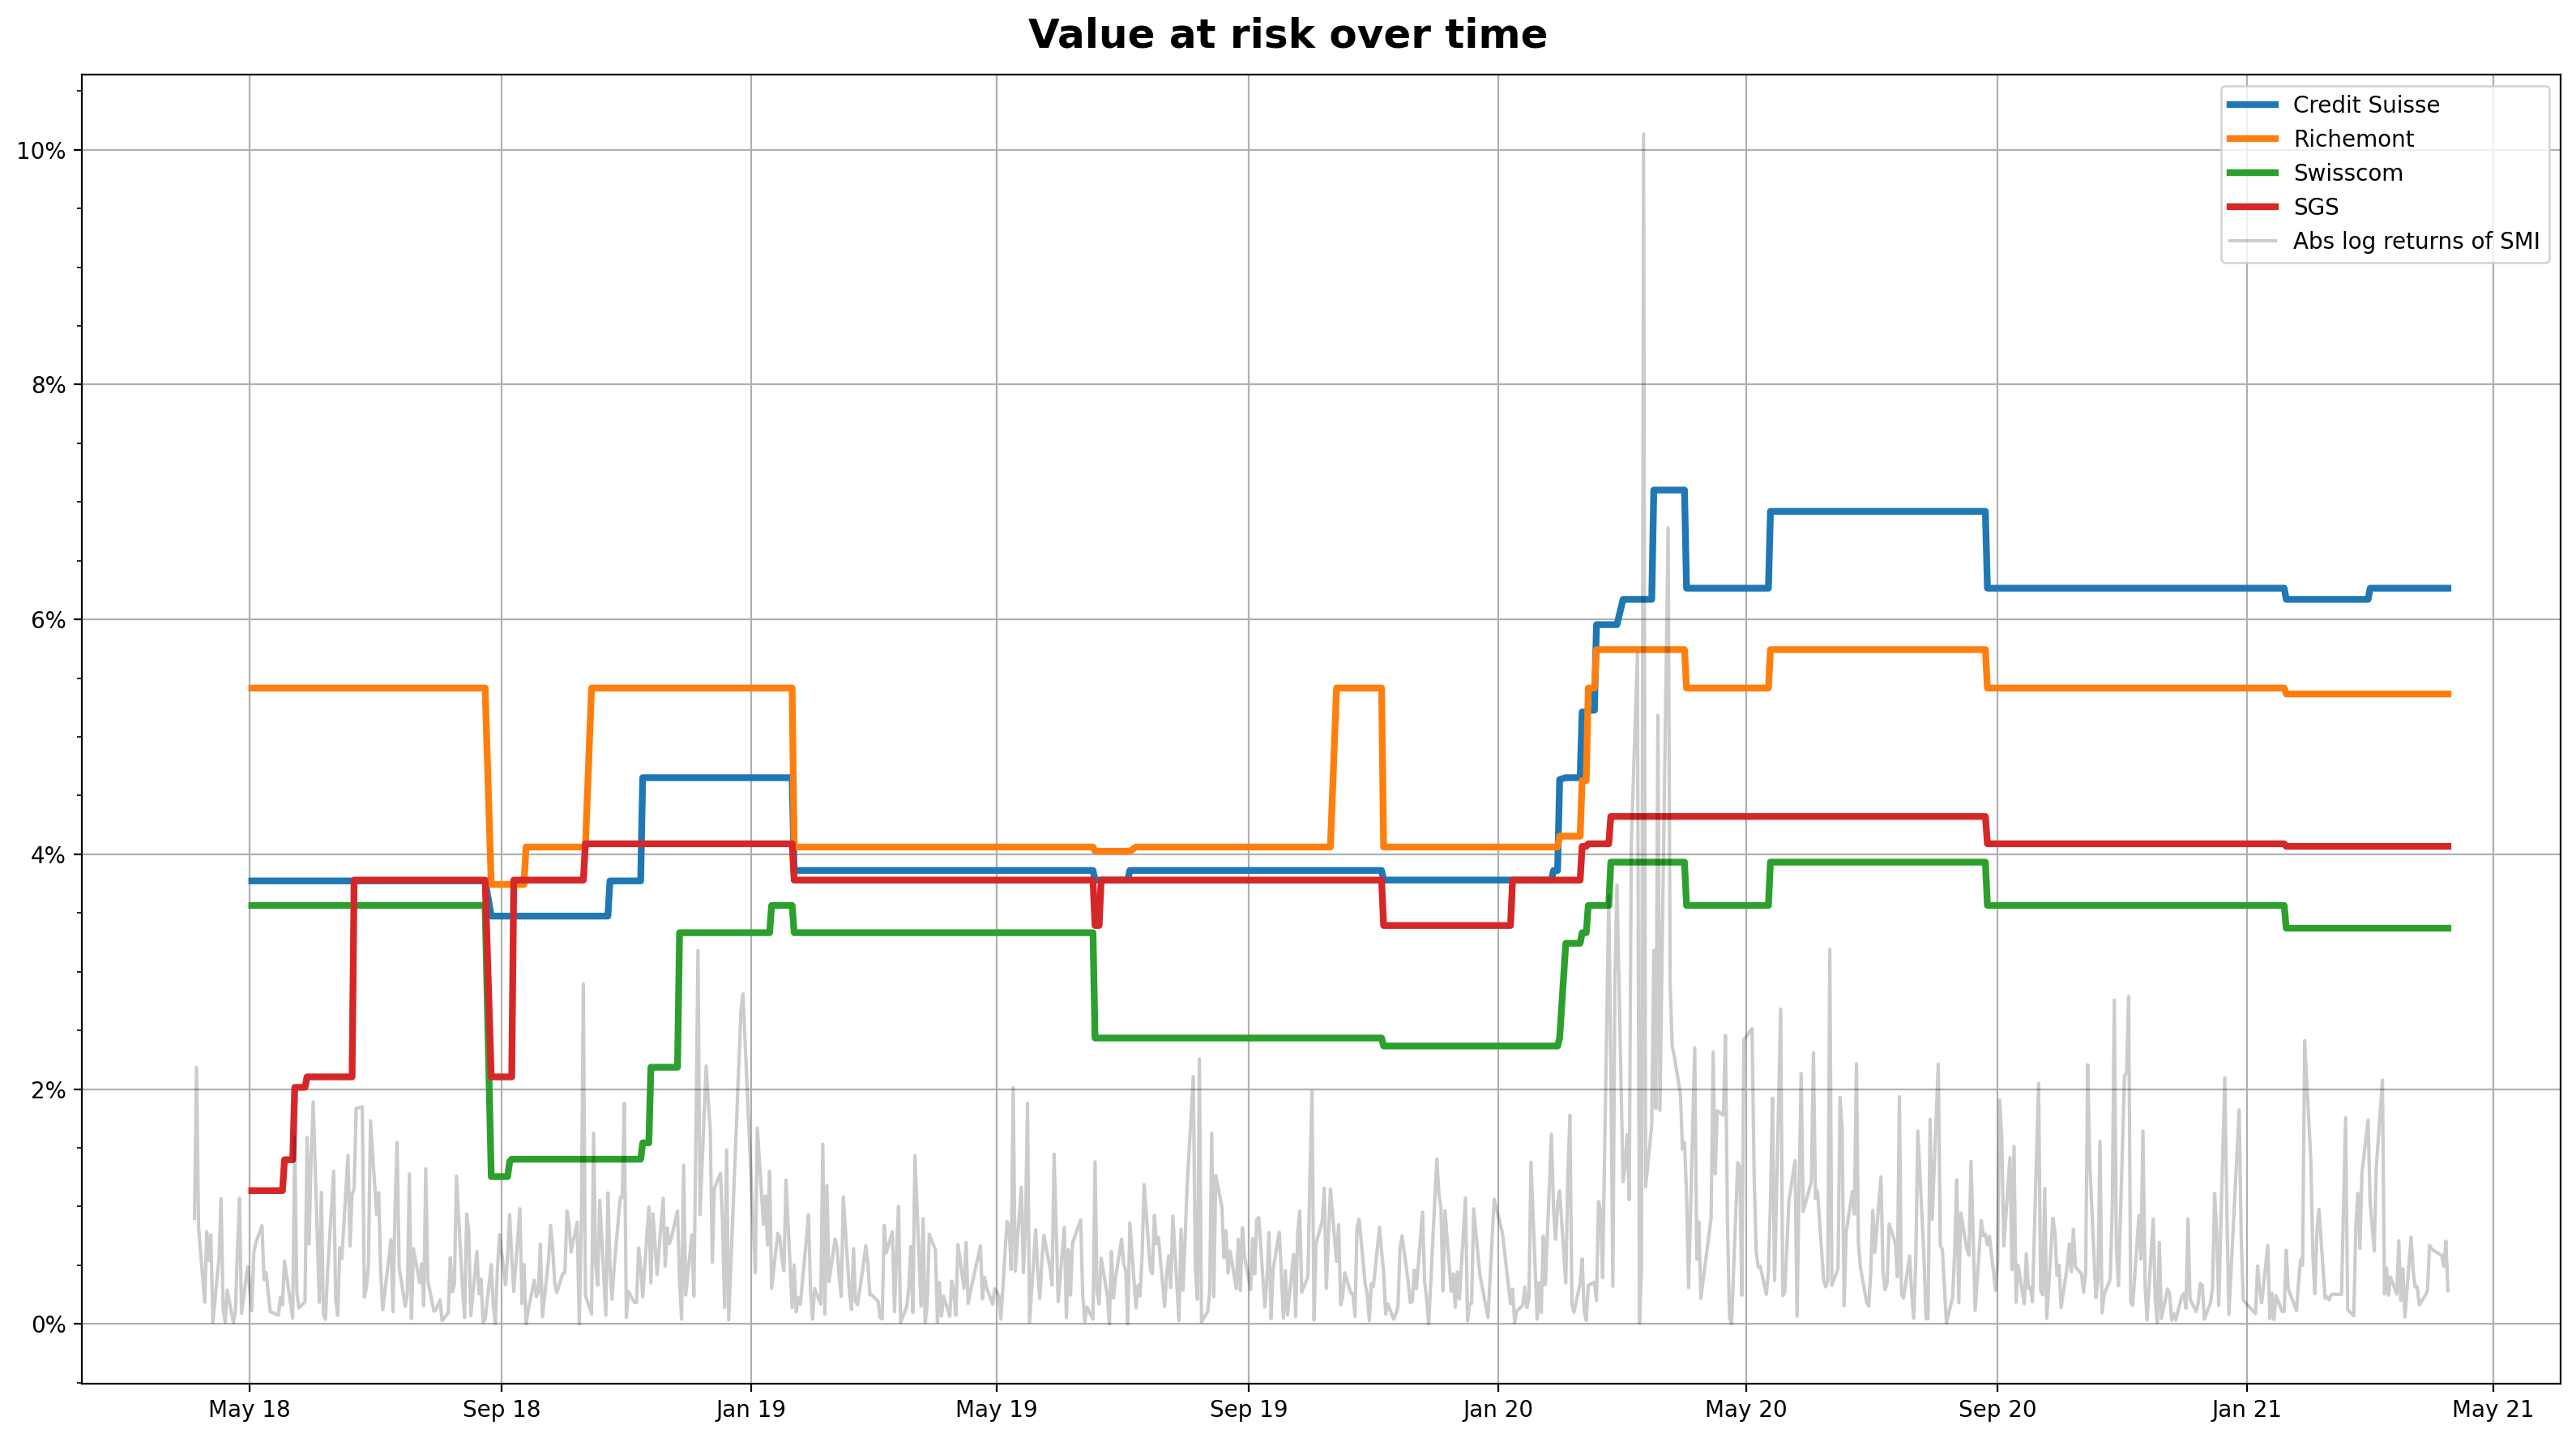

In [21]:
f_VaR, ax = plt.subplots(1,1,figsize=[16,9],dpi=200)

for i in range(4):
    ax.plot(
        VaR_series(selected_logs.iloc[:,i])*100,lw=3
    )
ax.plot(abs(smi20_logs*100),c='black',alpha=0.2)

ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.xaxis.set_major_locator(mdates.AutoDateLocator())    
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

legend = np.append(selected,'Abs log returns of SMI')
ax.legend(legend)
ax.grid()

plt.suptitle('Value at risk over time',fontweight='bold',fontsize=18)
plt.tight_layout()

In [22]:
# # Export

# smi_adtv_sorted.to_latex('output/stats/smi_adtv_sorted')
# adtv_sel.to_latex('output/stats/adtv_sel')
# describe_prices.to_latex('output/stats/describe_prices')
# describe_logs.to_latex('output/stats/describe_logs')
# sys_risk.to_latex('output/stats/sys_risk')
# corr.to_latex('output/stats/corr')
# corr_kendall.to_latex('output/stats/corr_kendall')
# corr_spearman.to_latex('output/stats/corr_spearman')

# f_prices.savefig('output/figures/prices.png')
# f_logs.savefig('output/figures/logs.png')
# f_vols.savefig('output/figures/vols.png')
# f_comp.savefig('output/figures/compounded.png')
# f_dist.savefig('output/figures/dist_hist.png')
# f_dist2.savefig('output/figures/dist_all.png')
# f_dist2tail.savefig('output/figures/dist_tails.png')
# f_VaR.savefig('output/figures/value_at_risk.png')